# Word2Vec x MBKm

## Import Data

In [ ]:
# Import libraries 
import re
import string
import nltk

import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from collections import Counter 

import gensim.downloader as api
from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score

tfds.disable_progress_bar()
nltk.download("stopwords")
nltk.download("punkt")

In [ ]:
# Load data 
dataset = tfds.load("imdb_reviews", as_supervised = True)
unsup_data = dataset["unsupervised"]

# Unsup
unsup_sens = [str(s[0].numpy()) for s in unsup_data] 

# DataFrame Unsup
df = pd.DataFrame(unsup_sens, columns = ["text"])

## Clean data

### Define function to clean and tokenize

In [3]:
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens
    
    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()                            # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)               # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)                    # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)                  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)         # Replace dash between words
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation

    tokens = tokenizer(text)                                            # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]                  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]                 # Remove digits
    tokens = [t for t in tokens if len(t) > 1]                          # Remove short tokens
    return tokens

### Apply function and remove duplicates

In [4]:
stop_words = set(stopwords.words("english"))

df["tokens"] = df["text"].map(lambda x: clean_text(x, word_tokenize, stop_words))

# Remove duplicated after preprocessing
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

### Check vocabulary

In [5]:
docs = df["text"].values
tokenized_docs = df["tokens"].values
vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)

In [6]:
vocab.most_common(10)

[('br', 114467),
 ('movie', 83804),
 ('film', 76140),
 ('one', 52238),
 ('like', 39851),
 ('good', 28801),
 ('even', 24223),
 ('time', 24029),
 ('would', 24025),
 ('really', 22801)]

### Load pretrained FastText

In [38]:
model = api.load("fasttext-wiki-news-subwords-300")
# model = Word2Vec(sentences=tokenized_docs, seed=42)

In [39]:
model.most_similar("movie")

[('film', 0.8769422769546509),
 ('movie-', 0.8271825313568115),
 ('movies', 0.7997194528579712),
 ('film--', 0.7811052799224854),
 ('movie.', 0.7665870189666748),
 ('film.', 0.7414735555648804),
 ('filmdom', 0.7352851629257202),
 ('mini-movie', 0.729194164276123),
 ('films', 0.7288245558738708),
 ('moviehouse', 0.728100061416626)]

## Generate vectors from document

### Define function for creating a single vectors from word embeddings

In [40]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

### Apply function to previously pre-processed text

In [ ]:
vectorized_docs = vectorize(tokenized_docs, model=model)

In [42]:
model.wv.most_similar("movie")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('film', 0.8769422769546509),
 ('movie-', 0.8271825313568115),
 ('movies', 0.7997194528579712),
 ('film--', 0.7811052799224854),
 ('movie.', 0.7665870189666748),
 ('film.', 0.7414735555648804),
 ('filmdom', 0.7352851629257202),
 ('mini-movie', 0.729194164276123),
 ('films', 0.7288245558738708),
 ('moviehouse', 0.728100061416626)]

### Generate and analyze clusters

In [64]:
def mbkmeans_clusters(X, k, mb=500, print_silhouette_values=False):
    """Generate clusters.

    Args:
        X: Matrix of features.
        k: Number of clusters.
        # mb: Size of mini-batches. Defaults to 500.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_


`Inertia` measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters ( K ).

In [66]:
clusterer, cluster_labels = mbkmeans_clusters(X=vectorized_docs, k=2, print_silhouette_values=True)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

For n_clusters = 2
Silhouette coefficient: 0.07
Inertia:901.8926307473923
Silhouette values:
    Cluster 1: Size:24972 | Avg:0.10 | Min:0.01 | Max: 0.24
    Cluster 0: Size:24534 | Avg:0.04 | Min:-0.05 | Max: 0.19


## Visualization

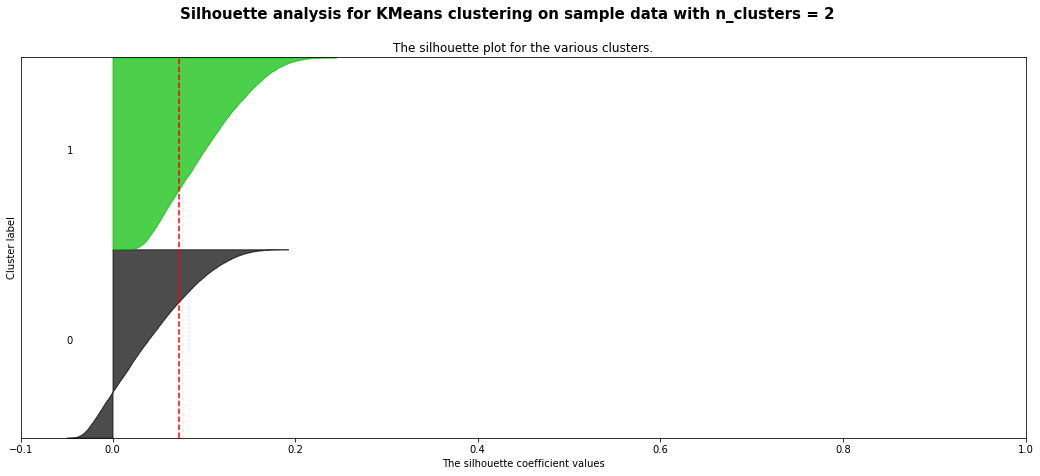

In [67]:
X = vectorized_docs
n_clusters = 2 

# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# Silhouette plot
# The silhouette coefficient can range from -1, 1
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(X, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=15,
        fontweight="bold")

plt.show()

In [69]:
print("Top terms per cluster (based on centroids):")
for i in range(2):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=15)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Top terms per cluster (based on centroids):
Cluster 0: toook meak bady just strory balnce seeen wory reaason excute shoild visble disgard steped proect 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


Cluster 1: toook meak strory bady balnce visble cooool fild thru-out excute furure grusome deline shoild non-one 


In [70]:
test_cluster = 0
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    print(docs[d])
    print("-------------")

b'Before I write this interview, I wanted to just explain that I have been a Dennis Miller fan since I was 11 (1994), and he was the only reason I saw this movie. I also think he was one of the aspects of this movie that held redeeming value. In addition, purchased it new for less than $10 a few years ago, and it is in my Halloween movie collection. With that out of the way, I\'ll start my review.<br /><br />Vampress Lilith (Angie Everhart) is brought to life again after a long rest in one of the far corners of the world by Reverend Jimmy Current (Chris Sarandon) and his partner Vincent. The two establish a bordello disguised as a funeral home to attract "evil" local young men. The men can "get stiff among the stiffs," but men start disappearing. This disappearance of local young men hits close to home for Katherine Verdoux(Erika Eleniak) when her rebellious younger brother Caleb (Corey Feldman) goes missing. So, she hires a Rafe Guttman (Dennis Miller) a wisecracking, seedy private in